In [17]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [18]:
import sys
import os

sys.path.append(os.path.abspath(".."))

from ARISA_DSML.preproc import get_raw_data
from ARISA_DSML.config import RAW_DATA_DIR, target

In [19]:
import os
from pathlib import Path
container_check = os.getenv("iscontainer")
if container_check=="y":
    config_dir = Path("/home/vscode/.config/kaggle")
    config_dir.mkdir(parents=True, exist_ok=True)

    with open(config_dir / "kaggle.json", "w") as dst:
        with open("../kaggle.json", "r") as src:
            dst.write(src.read())

In [20]:
get_raw_data()
!dir "{RAW_DATA_DIR}"

2025-05-08 20:13:40.855 | INFO     | ARISA_DSML.preproc:get_raw_data:21 - Downloading data to: /workspaces/Predict_cholesterol/ARISA_MLOps-Structure/data/raw


Dataset URL: https://www.kaggle.com/datasets/joannborkowska/cholesterol-supplementation-classification


2025-05-08 20:13:41.434 | INFO     | ARISA_DSML.preproc:get_raw_data:33 - Dataset download and extraction completed successfully


test_cholesterol.xlsx  train_choloesterol.xlsx


In [21]:
from ARISA_DSML.preproc import preprocess_df

train_path = preprocess_df(RAW_DATA_DIR / "train_choloesterol.xlsx")

In [22]:
import pandas as pd
df_train = pd.read_csv(train_path)

In [23]:
y_train = df_train.pop(target)
X_train = df_train

In [24]:
from ARISA_DSML.train import run_hyperopt

best_params_path = run_hyperopt(X_train, y_train)

2025-05-08 20:13:43.028 | INFO     | ARISA_DSML.train:run_hyperopt:69 - Best Parameters: {'depth': 5, 'learning_rate': 0.2995567111497413, 'iterations': 124, 'l2_leaf_reg': 0.11084080958223169, 'bagging_temperature': 0.9921093034173206, 'random_strength': 0.19224056696382372}


In [25]:
%reload_ext autoreload

In [26]:
import joblib
from ARISA_DSML.train import train_cv
params = joblib.load(best_params_path)
display(params)
n_folds = 5
cv_output_path = train_cv(X_train, y_train, params, n=n_folds)


{'depth': 5,
 'learning_rate': 0.2995567111497413,
 'iterations': 124,
 'l2_leaf_reg': 0.11084080958223169,
 'bagging_temperature': 0.9921093034173206,
 'random_strength': 0.19224056696382372}

Training on fold [0/5]


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.9890110	test: 0.8000000	best: 0.8000000 (0)	total: 3.04ms	remaining: 374ms
1:	learn: 1.0000000	test: 0.8000000	best: 0.8000000 (0)	total: 4.51ms	remaining: 275ms
2:	learn: 1.0000000	test: 1.0000000	best: 1.0000000 (2)	total: 5.2ms	remaining: 210ms
3:	learn: 1.0000000	test: 1.0000000	best: 1.0000000 (2)	total: 5.94ms	remaining: 178ms
4:	learn: 1.0000000	test: 1.0000000	best: 1.0000000 (2)	total: 6.58ms	remaining: 157ms
5:	learn: 1.0000000	test: 1.0000000	best: 1.0000000 (2)	total: 7.18ms	remaining: 141ms
6:	learn: 1.0000000	test: 1.0000000	best: 1.0000000 (2)	total: 7.78ms	remaining: 130ms
7:	learn: 1.0000000	test: 1.0000000	best: 1.0000000 (2)	total: 8.4ms	remaining: 122ms
8:	learn: 1.0000000	test: 1.0000000	best: 1.0000000 (2)	total: 9ms	remaining: 115ms
9:	learn: 1.0000000	test: 1.0000000	best: 1.0000000 (2)	total: 9.59ms	remaining: 109ms
10:	learn: 1.0000000	test: 1.0000000	best: 1.0000000 (2)	total: 10.2ms	remaining: 105ms
11:	learn: 1.0000000	test: 1.0000000	best: 1.00

In [27]:
from ARISA_DSML.train import plot_error_scatter
cv_results = pd.read_csv(cv_output_path)
plot_error_scatter(
    df_plot=cv_results,
    name="Mean F1 Score",
    title="Cross-Validation (N=5) Mean F1 score with Error Bands",
    xtitle="Training Steps",
    ytitle="Performance Score",
    yaxis_range=[0.5, 1],
)

In [28]:
plot_error_scatter(
    df_plot=cv_results,
    x="iterations",
    y="test-Logloss-mean",
    err="test-Logloss-std",
    name="Mean logloss",
    title="Cross-Validation (N=5) Mean Logloss with Error Bands",
    xtitle="Training Steps",
    ytitle="Logloss",
)

In [29]:
from ARISA_DSML.train import train

model_path, model_params_path = train(X_train, y_train, params)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

2025-05-08 20:13:45.330 | WARNING  | ARISA_DSML.train:train:150 - cv_results is not a DataFrame. Skipping cv metrics and plots.


0:	learn: 0.9747899	total: 1.36ms	remaining: 168ms
50:	learn: 1.0000000	total: 30ms	remaining: 42.9ms
100:	learn: 1.0000000	total: 56.6ms	remaining: 12.9ms
123:	learn: 1.0000000	total: 68.5ms	remaining: 0us


/home/codespace/.python/current/lib/python3.12/site-packages/mlflow/types/utils.py:452: UserWarning:

Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.

Registered model 'cholesterol-pred-bclass' already exists. Creating a new version of this model...
Created version '14' of model 'cholesterol-pred-bclass'.
/workspaces/Predict_cholesterol/ARISA_MLOps-Structure/ARISA_DSML/train.py:160: FutureW

In [30]:
dataset_test_path = RAW_DATA_DIR / "test_cholesterol.xlsx"
preprocced_test_path = preprocess_df(dataset_test_path)
df_test = pd.read_csv(preprocced_test_path)


{'depth': 5,
 'learning_rate': 0.2995567111497413,
 'iterations': 124,
 'l2_leaf_reg': 0.11084080958223169,
 'bagging_temperature': 0.9921093034173206,
 'random_strength': 0.19224056696382372,
 'eval_metric': 'F1',
 'loss_function': 'Logloss'}

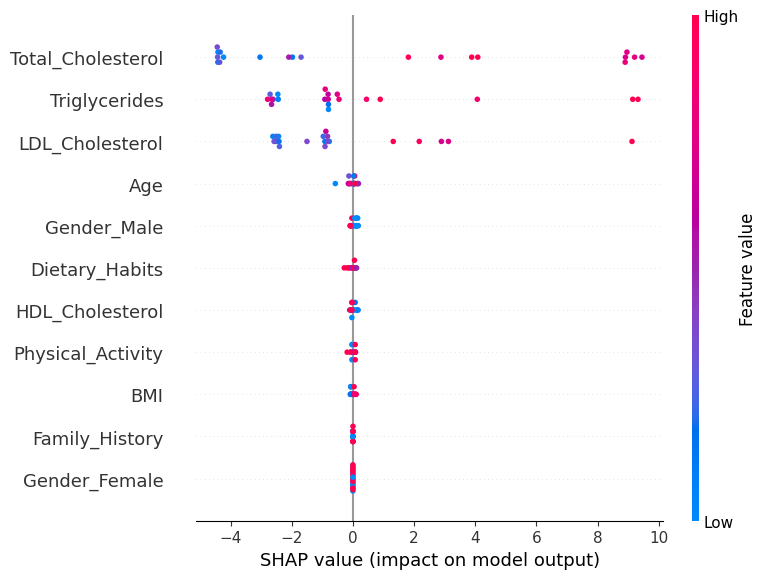

In [31]:
from ARISA_DSML.predict import predict
from catboost import CatBoostClassifier

params = joblib.load(model_params_path)
display(params)
from_file = CatBoostClassifier()
model = from_file.load_model(str(model_path))
preds_path = predict(model, df_test, params)